# Forward

Hey all. This is a for of @bminixhofer Kernel. My only addition is to demonstrate the use variable batch size for accelerated training times, and of course I use my picked embeddings which load faster and help with memory management.

# Preface

This kernel is a PyTorch version of the [Simple LSTM kernel](https://www.kaggle.com/thousandvoices/simple-lstm). All credit for architecture and preprocessing goes to @thousandvoices.
There is a lot of discussion whether Keras, PyTorch, Tensorflow or the CUDA C API is best. But specifically between the PyTorch and Keras version of the simple LSTM architecture, there are 2 clear advantages of PyTorch:
- Speed. The PyTorch version runs about 20 minutes faster.
- Determinism. The PyTorch version is fully deterministic. Especially when it gets harder to improve your score later in the competition, determinism is very important.

I was surprised to see that PyTorch is that much faster, so I'm not completely sure the steps taken are exactly the same. If you see any difference, we can discuss it in the comments :)

The most likely reason the score of this kernel is higher than the @thousandvoices version is that the optimizer is not reinitialized after every epoch and thus the parameter-specific learning rates of Adam are not discarded after every epoch. That is the only difference between the kernels that is intended.

# Imports & Utility functions

In [79]:
import numpy as np
import pandas as pd
import os, time, gc, pickle, random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from pytorch_pretrained_bert import BertTokenizer, BertModel
import apex
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

SMALL_DATA = False

# Logging for BERT
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
print("ASd")

In [15]:
# disable progress bars when submitting
def is_interactive():
    return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

In [16]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [17]:
CRAWL_EMBEDDING_PATH = '../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl'
GLOVE_EMBEDDING_PATH = '../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'

NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

In [18]:
def build_matrix(word_index, emb_path, unknown_token='unknown'):
    with open(emb_path, 'rb') as fp:
        embedding_index = pickle.load(fp)
    
    # TODO: Build random token instead of using unknown
    unknown_token = embedding_index[unknown_token].copy()
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word].copy()
        except KeyError:
            embedding_matrix[i] = unknown_token
            unknown_words.append(word)
            
    del embedding_index; gc.collect()
    return embedding_matrix, unknown_words

In [19]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [20]:
# helper functions
string.printable
ascii_chars = string.printable
ascii_chars += " áéíóúàèìòùâêîôûäëïöüñõç"

#checks if a string of text contains any nonenglish characters (excluding punctuations, spanish, and french characters)
def contains_non_english(text):
    if all(char in ascii_chars for char in text):
        return 0
    else:
        return 1
    
#clean non english characters from string of text
def remove_non_english(text):
    return ''.join(filter(lambda x: x in ascii_chars, text))


def get_first_word(word):
    if(type(word) != "float"):
        return word.split(" ")[0]
    return "-1"

def get_cap_vs_length(row):
    if row["total_length"] == 0:
        return -1
    return float(row['capitals'])/float(row['total_length'])

def calc_max_word_len(sentence):
    maxLen = 0
    for word in sentence:
        maxLen = max(maxLen, len(word))
    return maxLen

def calc_min_word_len(sentence):
    minLen = 999999
    for word in sentence:
        minLen = min(minLen, len(word))
    return minLen

def calc_total_word_len(sentence):
    cnt = 0
    for x in sentence:
        cnt+=len(x)
    return cnt

def calc_total_unique_word_len(sentence):
    words = set(sentence)
    return calc_total_word_len(words)

#removes all single characters except for "I" and "a"
def remove_singles(text):
    return ' '.join( [w for w in text.split() if ((len(w)>1) or (w.lower() == "i") or (w.lower() == "a"))] )
    
#combines multiple whitespaces into single
def clean_text(x):
    x = str(x)
    x = x.replace("-", '')
    x = x.replace("/", '')
    x = x.replace("'",'')
    x = re.sub( '\s+', ' ', x).strip()
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [58]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    
    # Text cleaning
    
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text
    
    # TODO: speed up this func
    def pad_chars(text,punct):
        for p in punct:
            text = re.sub('(?<=\w)([!?,])', r' \1', text)
        return text
    
    # Feature generation
    
    def gen_feats(df):
        #df = pd.concat([train.loc[:, 'qid' : 'comment_text'], test], sort = 'False')

        print("--- Generating non_eng")
        df["non_eng"] = df["comment_text"].map(lambda x: contains_non_english(x))

        print("--- Generating first_word")
        df["first_word"] = df["comment_text"].map(lambda x: get_first_word(x))

        print("--- Generating total_length (num chars)")
        df['total_length'] = df['comment_text'].apply(len)

        print("--- Generating capitals")
        df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))

        print("--- Generating caps_vs_length")
        df['caps_vs_length'] = df.apply(lambda row: get_cap_vs_length(row),axis=1)

        #print("--- Generating num_exclamation_marks")
        #df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))

        print("--- Generating num_question_marks")
        df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))

        print("--- Generating num_punctuation")
        df['num_punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))

        #print("--- Generating num_symbols")
        #df['num_symbols'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))

        print("--- Generating num_words")
        df['num_words'] = df['comment_text'].apply(lambda comment: len(re.sub(r'[^\w\s]','',comment).split(" ")))

        print("--- Generating num_unique_words")
        df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))

        print("--- Generating unique_word_over_num_words")
        df['unique_word_over_num_words'] = df['num_unique_words'] / test['num_words']

        #print("--- Generating num_smilies")
        #df['num_smilies'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

        print("--- Generating num_sentences")
        df['num_sentences'] = df['comment_text'].apply(lambda comment: len(re.split(r'[.!?]+', comment)))

        print("--- Generating max_word_len")
        df['max_word_len'] = df['comment_text'].apply(lambda comment: calc_max_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating min_word_len")
        df['max_word_len'] = df['comment_text'].apply(lambda comment: calc_min_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating total_word_length (num of chars in words)")
        df['total_word_length'] = df['comment_text'].apply(lambda comment: calc_total_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating avg_word_len")
        df['avg_word_len'] = df['total_word_length'] / df['num_words']
        
        print("--- Generating total_unique_word_length (num of chars in words)")
        df['total_unique_word_length'] = df['comment_text'].apply(lambda comment: calc_total_unique_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating avg_unique_word_len")
        df['avg_unique_word_len'] = df['total_unique_word_length'] / df['num_unique_words']
        

    def cleanText(df):
        print("--- cleaning text")
        df["comment_text"] = df["comment_text"].apply(lambda x: clean_text(x))

        print("--- remove single characters")
        df["comment_text"] = df["comment_text"].apply(lambda x: remove_singles(x))

        print("--- cleaning numbers")
        df["comment_text"] = df["comment_text"].apply(lambda x: clean_numbers(x))

        print("--- cleaning misspellings")
        df["comment_text"] = df["comment_text"].apply(lambda x: replace_typical_misspell(x))

        print("--- filling missing values")
        #clean chinese, korean, japanese characters
        print('cleaning characters')
        df["comment_text"] = df["comment_text"].map(lambda x: remove_non_english(x))

        ## fill up the missing values
        df["comment_text"].fillna("").values

        #for getting num good and bad words
        from wordcloud import STOPWORDS
        from collections import defaultdict
        import operator

        train1_df = train[train["target"]==1]
        train0_df = train[train["target"]==0]

        ## custom function for ngram generation ##
        def generate_ngrams(text, n_gram=1):
            token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
            ngrams = zip(*[token[i:] for i in range(n_gram)])
            return [" ".join(ngram) for ngram in ngrams]

        freq_dict_bad = defaultdict(int)
        for sent in train1_df["comment_text"]:
            for word in generate_ngrams(sent):
                freq_dict_bad[word] += 1
        freq_dict_bad = dict(freq_dict_bad)

        freq_dict_good = defaultdict(int)
        for sent in train0_df["comment_text"]:
            for word in generate_ngrams(sent):
                freq_dict_good[word] += 1
        freq_dict_good = dict(freq_dict_good)

        bad_words = sorted(freq_dict_bad, key=freq_dict_bad.get, reverse=True)[:1000]
        good_words = sorted(freq_dict_good, key=freq_dict_good.get, reverse=True)[:1000]

        print("--- Generating num_bad_words")
        train["num_bad_words"] = train["comment_text"].map(lambda x: num_bad_words(x))
        test["num_bad_words"] = test["comment_text"].map(lambda x: num_bad_words(x))

        print("--- Generating num_good_words")
        train["num_good_words"] = train["comment_text"].map(lambda x: num_good_words(x))
        test["num_good_words"] = test["comment_text"].map(lambda x: num_good_words(x))

    gen_feats(data)
    #data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    data["comment_text"] = data["comment_text"].astype(str).apply(lambda x: pad_chars(x, punct))
    return data

# Preprocessing

In [62]:
train = pd.read_hdf('../input/train.h5')
test = pd.read_hdf('../input/test.h5')

if (SMALL_DATA):
    train = train[:100]
    test = test[:100]

start_time = time.time()
print("Preprocessing data ...")
x_test = preprocess(test)
x_train = preprocess(train)
print("--- %s seconds ---" % (time.time() - start_time))

y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']].values

Preprocessing data ...
--- Generating non_eng
--- Generating first_word
--- Generating total_length (num chars)
--- Generating capitals
--- Generating caps_vs_length
--- Generating num_question_marks
--- Generating num_punctuation
--- Generating num_words
--- Generating num_unique_words
--- Generating unique_word_over_num_words
--- Generating num_sentences
--- Generating max_word_len
--- Generating min_word_len
--- Generating total_word_length (num of chars in words)
--- Generating avg_word_len
--- Generating total_unique_word_length (num of chars in words)
--- Generating avg_unique_word_len
--- Generating non_eng
--- Generating first_word
--- Generating total_length (num chars)
--- Generating capitals
--- Generating caps_vs_length
--- Generating num_question_marks
--- Generating num_punctuation
--- Generating num_words
--- Generating num_unique_words
--- Generating unique_word_over_num_words
--- Generating num_sentences
--- Generating max_word_len
--- Generating min_word_len
--- Gener

In [80]:
train

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,num_punctuation,num_words,num_unique_words,unique_word_over_num_words,num_sentences,max_word_len,total_word_length,avg_word_len,total_unique_word_length,avg_unique_word_len
0,59848,0.000000,"This is so cool. It's like , 'would you want y...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,3,19,19,0.760000,4,2,74,3.894737,74,3.894737
1,59849,0.000000,Thank you !! This would make my life a lot les...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2,22,22,0.349206,4,1,86,3.909091,86,3.909091
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2,16,16,0.285714,3,2,68,4.250000,68,4.250000
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,0,17,16,0.129032,3,2,65,3.823529,63,3.937500
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.000000,...,1,8,8,0.222222,2,1,28,3.500000,28,3.500000
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,...,1,4,4,0.125000,2,1,15,3.750000,15,3.750000
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,...,1,3,3,0.333333,2,2,24,8.000000,24,8.000000
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,0,1,1,0.032258,1,19,19,19.000000,19,19.000000
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2,21,20,0.113636,2,2,98,4.666667,96,4.800000
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2,18,17,0.133858,3,1,60,3.333333,56,3.294118


In [65]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [ ]:
sns.distplot(x_train["avg_word_len"])

In [ ]:
for i, col in enumerate(x_train.columns):
    plt.figure(i)
    sns.distplot(x_train[col])

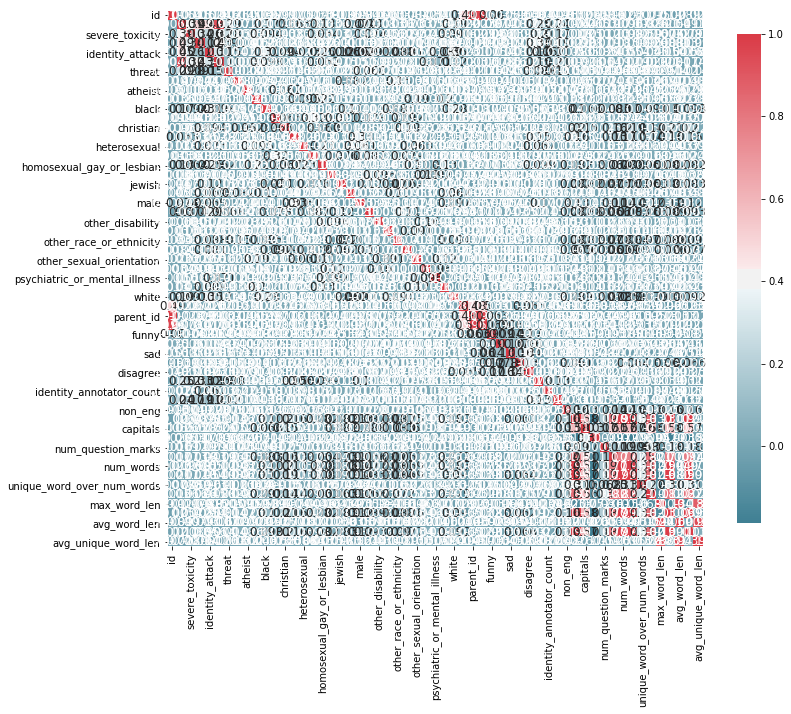

In [71]:
plot_correlation_map(x_train)

In [72]:
describe_more(x_train)

,Variable,Levels,Datatype
45,non_eng,2,int64
36,rating,2,object
38,wow,15,int64
39,sad,25,int64
50,num_question_marks,47,int64
33,publication_id,53,int64
37,funny,61,int64
55,num_sentences,62,int64
12,buddhist,64,float64
18,intellectual_or_learning_disability,76,float64


In [74]:
print(set(x_train["total_unique_word_length"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [78]:
x_train[x_train["total_unique_word_length"] == 800].iloc[0]

id                                                                                376419
target                                                                          0.327586
comment_text                           I'm goinna Oooh ! and Awe ! until you puke.  O...
severe_toxicity                                                                        0
obscene                                                                        0.0689655
identity_attack                                                                        0
insult                                                                          0.155172
threat                                                                         0.0172414
asian                                                                                NaN
atheist                                                                              NaN
bisexual                                                                             NaN
black                

In [63]:
print("asd")

asd


In [50]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_text = []
for x in enu= tokenizer.tokenize(text)

SyntaxError: invalid syntax (<ipython-input-50-e780ebfc8201>, line 4)

In [12]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)
x_train_lens = [len(i) for i in x_train]
x_test_lens  = [len(i) for i in x_test]

In [13]:
max_features = None
max_features = max_features or len(tokenizer.word_index) + 1
max_features

327576

In [14]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, emb_path=CRAWL_EMBEDDING_PATH, unknown_token='unknown')
print('n unknown words (crawl): ', len(unknown_words_crawl))

FileNotFoundError: [Errno 2] No such file or directory: '../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl'

In [ ]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, emb_path=GLOVE_EMBEDDING_PATH, unknown_token='unknown')
print('n unknown words (glove): ', len(unknown_words_glove))

In [ ]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

# Batching

In [ ]:
class TextDataset(data.Dataset):
    def __init__(self, text, lens, y=None):
        self.text = text
        self.lens = lens
        self.y = y

    def __len__(self):
        return len(self.lens)

    def __getitem__(self, idx):
        if self.y is None:
            return self.text[idx], self.lens[idx]
        return self.text[idx], self.lens[idx], self.y[idx]

In [ ]:
class Collator(object):
    def __init__(self,test=False,percentile=100):
        self.test = test
        self.percentile = percentile
        
    def __call__(self, batch):
        global MAX_LEN
        
        if self.test:
            texts, lens = zip(*batch)
        else:
            texts, lens, target = zip(*batch)

        lens = np.array(lens)
        max_len = min(int(np.percentile(lens, self.percentile)), MAX_LEN)
        texts = torch.tensor(sequence.pad_sequences(texts, maxlen=max_len), dtype=torch.long).cuda()
        
        if self.test:
            return texts
        
        return texts, torch.tensor(target, dtype=torch.float32).cuda()

In [ ]:
final_y_train = np.hstack([y_train[:, np.newaxis], y_aux_train])

train_collate = Collator(percentile=96)
train_dataset = TextDataset(x_train, x_train_lens, final_y_train)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=train_collate)

test_collate = Collator(test=True)
test_dataset = TextDataset(x_test, x_test_lens)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False , collate_fn=test_collate)

# del y_train, y_aux_train; gc.collect()

# Training

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def train_model(model, train_loader, test_loader, loss_fn, output_dim, lr=0.001,
                batch_size=512, n_epochs=4,
                enable_checkpoint_ensemble=True):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        
        for step, (seq_batch, y_batch) in enumerate(tqdm(train_loader, disable=False)):
            y_pred = model(seq_batch)            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() #/ len(train_loader)
            
            if step > 0 and step % 100 == 0:
                print(step, avg_loss / step)
            
        model.eval()
        test_preds = np.zeros((len(test), output_dim))
    
        for step, seq_batch in enumerate(test_loader):
            y_pred = sigmoid(model(seq_batch).detach().cpu().numpy())
            test_preds[step * batch_size:step * batch_size + y_pred.shape[0], :] = y_pred[:,:1]

        all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss / len(train_loader), elapsed_time))

    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
        
    return test_preds

In [ ]:
aux_size = final_y_train.shape[-1] - 1  # targets

all_test_preds = []
for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    
    model = NeuralNet(embedding_matrix, aux_size)
    model.cuda()
    
    test_preds = train_model(model, train_loader, test_loader, output_dim=1, loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
    all_test_preds.append(test_preds)
    print()

In [ ]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': np.mean(all_test_preds, axis=0)[:, 0]
})

submission.to_csv('submission.csv', index=False)

Note that the solution is not validated in this kernel. So for tuning anything, you should build a validation framework using e. g. KFold CV. If you just check what works best by submitting, you are very likely to overfit to the public LB.

# Ways to improve this kernel

This kernel is just a simple baseline kernel, so there are many ways to improve it. Some ideas to get you started:
- ~~Use bucketing to train faster and fit more networks into the two hours. The winning team of the quora competition successfully used bucketing to drastically reduce the time it took to train RNNs. An excerpt from their [solution summary](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80568#latest-487092):~~
- Add a contraction mapping. E. g. mapping "is'nt" to "is not" can help the network because "not" is explicitly mentioned. They were very popular in the recent quora competition, see for example [this kernel](https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing).
- Try to reduce the number of words that are not found in the embeddings. At the moment, around 170k words are not found. We can take some steps to decrease this amount, for example trying to find a vector for a processed (capitalized, stemmed, ...) version of the word when the vector for the regular word can not be found. See the [3rd place solution](https://www.kaggle.com/wowfattie/3rd-place) of the quora competition for an excellent implementation of this.
- Try cyclic learning rate (CLR). I have found CLR to almost always improve my network recently compared to the default parameters for Adam. In this case, we are already using a learning rate scheduler, so this might not be the case. But it is still worth to try it out. See for example my [my other PyTorch kernel](https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch) for an implementation of CLR in PyTorch.

> We aimed at combining as many models as possible. To do this, we needed to improve runtime and the most important thing to achieve this was the following. We do not pad sequences to the same length based on the whole data, but just on a batch level. That means we conduct padding and truncation on the data generator level for each batch separately, so that length of the sentences in a batch can vary in size. Additionally, we further improved this by not truncating based on the length of the longest sequence in the batch, but based on the 95% percentile of lengths within the sequence. This improved runtime heavily and kept accuracy quite robust on single model level, and improved it by being able to average more models.

- Try a (weighted) average of embeddings instead of concatenating them. A 600d vector for each word is a lot, it might work better to average them instead. See [this paper](https://www.aclweb.org/anthology/N18-2031) for why this even works.
- Limit the maximum number of words used to train the NN. At the moment, there is no limit set to the maximum number of words in the tokenizer, so we use every word that occurs in the training data, even if it is only mentioned once. This could lead to overfitting so it might be better to limit the maximum number of words to e. g. 100k.

Thanks for reading. Good luck and have fun in this competition!

Happy Kaggling!